In [1]:
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

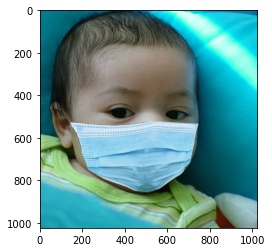

In [3]:
img_array = cv2.imread("mask/00000_Mask.jpg")
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

In [5]:
img_array.shape      ## Shape of image

(1024, 1024, 3)

In [21]:
directory = "dataset/"
classes = ["masked","not_masked"]
img_size = 224  ## ImageNet => 224
training_data = []   

def create_training_data(directory,classes,img_size):
    for category in classes:
        for path in glob.glob(directory+category+"/*"):
            try:
                img = cv2.imread(path)
                new_img = cv2.resize(img,(img_size,img_size))
                training_data.append([new_img,category])
            except Exception as e:
                pass

In [23]:
create_training_data(directory,classes,img_size)

In [25]:
print(len(training_data))

1950


In [26]:
import random
random.shuffle(training_data)

In [27]:
X = []  ## Features
y = []  ## Labels

for features, labels in training_data:
    X.append(features)
    y.append(labels)
    
X = np.array(X).reshape(-1,img_size,img_size,3)

In [28]:
X.shape

(1950, 224, 224, 3)

In [32]:
## Normalize the data
X = X/255

In [41]:
len(y)

1950

In [46]:
for i in range(0,len(y)):
    if(y[i] == 'masked'):
        y[i]= 0
    elif(y[i] == 'not_masked'):
        y[i] = 1

In [50]:
Y = np.array(y)

In [52]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [53]:
#pickle_in = open("X.pickle","rb")
#X = pickle.load(pickle_in)

#pickle_in = open("y.pickle","rb")
#y = pickle.load(pickle_in)

## Deep learning model - Transfer Learning

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [68]:
model = tf.keras.applications.mobilenet.MobileNet()  ## Pre-trained model

In [69]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [70]:
base_input = model.layers[0].input

In [71]:
base_output = model.layers[-4].output

In [72]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(flat_layer)
final_out = layers.Activation('sigmoid')(final_output)

In [73]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [74]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [75]:
new_model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [76]:
new_model.fit(X,Y, epochs=1, validation_split= 0.1)

55/55 [==============================] - 163s 3s/step - loss: 0.1720 - accuracy: 0.9858 - val_loss: 2.4652 - val_accuracy: 0.8205


In [2]:
new_model = tf.keras.models.load_model("face_mask.h5")

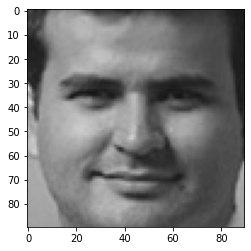

In [3]:
test = cv2.imread("D:/Trainings/python_with_ML_Ducat_INdustrial_training/resource/jupyter/DATASETS/gender_training/train/male/male_0.jpg")
plt.imshow(cv2.cvtColor(test,cv2.COLOR_BGR2RGB))

In [4]:
test_img = cv2.resize(test,(224,224))
test_img = np.expand_dims(test_img,axis = 0)
test_img = test_img/255

In [5]:
x = new_model.predict(test_img)

1/1 [==============================] - 1s 690ms/step


In [6]:
if (x>0):
    print(True)

True


In [13]:
video = cv2.VideoCapture(0)
face_model = cv2.CascadeClassifier("D:/Trainings/python_with_ML_Ducat_INdustrial_training/resource/jupyter/DATASETS/haar/haarcascade_frontalface_default.xml")

while(True):
    
    flag, img = video.read()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.flip(gray,1)
    img = cv2.flip(img,1)
    
    if(flag == False):
        break
        
    list_faces = face_model.detectMultiScale(gray,1.1,4)
    
    for x,y,w,h in list_faces:
        face = img[y:y+h, x:x+h]
        face = cv2.resize(face,(224,224))
        face = np.expand_dims(face,axis=0)
        face = face/255.0
        
        pred = new_model.predict(face,verbose=0)
        
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        
        if(pred>0):
            cv2.putText(img,"No mask",(x,y+10),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
        
        else:
            cv2.putText(img,"Masked",(x,y+10),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
        
    cv2.imshow("a",img)
    k = cv2.waitKey(1)
    if(k==ord('a')):
        break
        
cv2.destroyAllWindows()
video.release()